In [1]:
import pandas as pd

# Lade das bereits normalisierte und gebalancte Dataset
data = pd.read_csv("balanced_data.csv")
print(data.shape)


(61875, 92)


In [4]:
import pandas as pd
import numpy as np

# Daten laden
data = pd.read_csv("balanced_data.csv")

# Nur Feature-Spalten ohne 'target'
feature_cols = data.columns.drop('target')
data_features = data[feature_cols]

# Set zum Speichern aller Outlier-Zeilen
outlier_indices = set()

# Für jedes Feature: 10 stärkste Abweichungen vom Mittelwert
for feat in feature_cols:
    deviation = np.abs(data_features[feat] - data_features[feat].mean())
    top10_idx = deviation.nlargest(10).index
    outlier_indices.update(top10_idx)

print(f"Anzahl eindeutiger Zeilen, die entfernt werden: {len(outlier_indices)}")

# Entferne die Zeilen aus dem Original-Datensatz
data_cleaned = data.drop(index=outlier_indices).reset_index(drop=True)

# Speichern
data_cleaned.to_csv("balanced_dataV2.csv", index=False)
print("✅ balanced_dataV2.csv wurde gespeichert.")


Anzahl eindeutiger Zeilen, die entfernt werden: 819
✅ balanced_dataV2.csv wurde gespeichert.


In [5]:
print(data['target'].value_counts())
print(data_cleaned['target'].value_counts())


target
1    6875
2    6875
3    6875
4    6875
5    6875
6    6875
7    6875
8    6875
9    6875
Name: count, dtype: int64
target
5    6865
4    6861
3    6825
2    6816
1    6800
7    6790
9    6747
6    6736
8    6616
Name: count, dtype: int64


In [6]:
def plot_grid_search_2d(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
# Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1),len(grid_param_2))
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_1):
        ax.plot(grid_param_2, scores_mean[idx,:], '-o', label= name_param_1 + ': ' + str(val))
        ax.set_title("Grid Search Scores", fontsize=12, fontweight='bold')
        ax.set_xlabel(name_param_2, fontsize=10)
        ax.set_ylabel('CV Average Validation Accuracy', fontsize=10)
        ax.legend(loc="best", fontsize=8)
        ax.grid('on')

In [7]:
### Function to visualize the results of Grid Search with 3 hyperparameters ###
def plot_grid_search_3d(cv_results, grid_param_1, grid_param_2, grid_param_3, name_param_1, name_param_2, name_param_3):
    """
    Plots a grid search result for 3 hyperparameters as a series of 2D plots (one for each value of grid_param_3).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    scores_mean = np.array(cv_results['mean_test_score'])
    # Reshape to (len(grid_param_1), len(grid_param_2), len(grid_param_3))
    scores_mean = scores_mean.reshape(len(grid_param_1), len(grid_param_2), len(grid_param_3))

    for idx3, val3 in enumerate(grid_param_3):
        _, ax = plt.subplots(1, 1, figsize=(7, 5))
        for idx1, val1 in enumerate(grid_param_1):
            ax.plot(grid_param_2, scores_mean[idx1, :, idx3], '-o', label=f"{name_param_1}: {val1}")
        ax.set_title(f"Grid Search Scores ({name_param_3}: {val3})", fontsize=12, fontweight='bold')
        ax.set_xlabel(name_param_2, fontsize=10)
        ax.set_ylabel('CV Average Validation Accuracy', fontsize=10)
        ax.legend(loc="best", fontsize=8)
        ax.grid(True)
        plt.show()

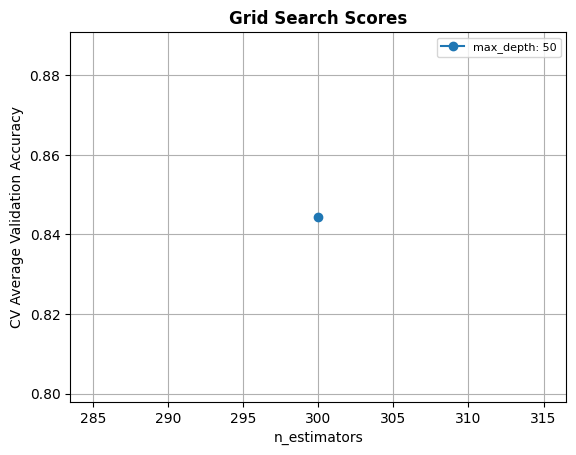

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

balanced_data = pd.read_csv("balanced_dataV2.csv")
# Features und Ziel
X = balanced_data.drop(columns='target')
Y = balanced_data['target']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=22)

# Klassifikationsmodell
RForClassCV = RandomForestClassifier(random_state=0)
#gini und anderes ausporbieren
# Grid definieren
param_grid = {
    'max_depth': [50],
    'n_estimators': [300],
    'criterion': ['gini'],
    'min_samples_leaf': [1]
}

# GridSearchCV Setup
model = RandomForestClassifier(random_state=0)
grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid.fit(X_train, Y_train)

# Plot aufrufen
import matplotlib.pyplot as plt
plot_grid_search_2d(grid.cv_results_, param_grid['max_depth'], param_grid['n_estimators'],'max_depth', 'n_estimators')

plt.show()

Train Accuracy: 0.9997
Test Accuracy: 0.8587


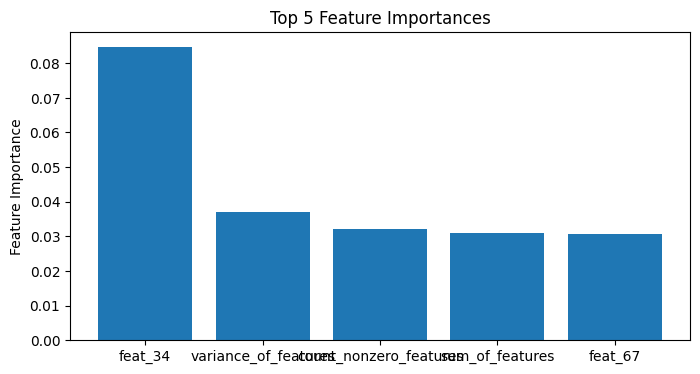

In [10]:
# Klassifikationsmodell mit besten Parametern aus CV
final_rf_clf = RandomForestClassifier(random_state=0)
final_rf_clf.set_params(**grid.best_params_)

# Modell trainieren
final_rf_clf.fit(X_train, Y_train)

# Accuracy auf Trainings- und Testdaten berechnen
train_acc = final_rf_clf.score(X_train, Y_train)
test_acc = final_rf_clf.score(X_test, Y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# View a list of the features and their importance scores
import matplotlib.pyplot as plt

feature_importances = list(zip(X_train.columns, final_rf_clf.feature_importances_))
# Sort by importance descending and take top 5
top_features = sorted(feature_importances, key=lambda x: x[1], reverse=True)[:5]

# Unzip for plotting
features, importances = zip(*top_features)

plt.figure(figsize=(8, 4))
plt.bar(features, importances)
plt.ylabel("Feature Importance")
plt.title("Top 5 Feature Importances")
plt.show()



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Daten laden
data = pd.read_csv("balanced_dataV2.csv")

# Annahme: Die Zielvariable heißt 'target' und die restlichen Spalten sind Features
X = data.drop('target', axis=1)  # Features
y = data['target']  # Zielvariable

# Falls die Zielvariable kategorisch ist, encode sie (z.B. 'Class_1', 'Class_2', ...)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=22)


In [13]:
import xgboost as xgb

# XGBoost-Modell initialisieren
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Für Multiclass-Klassifikation
    num_class=len(np.unique(y_encoded)),  # Anzahl der Klassen
    eval_metric='mlogloss',  # Metrik für Multiclass
    random_state=0
)

# Modell trainieren
xgb_model.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Vorhersagen auf Testdaten
y_pred = xgb_model.predict(X_test)

# Genauigkeit berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detaillierte Auswertung
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

# Konfusionsmatrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8474

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.87      0.86      1421
           2       0.71      0.67      0.69      1349
           3       0.66      0.66      0.66      1331
           4       0.83      0.86      0.84      1356
           5       0.98      0.99      0.98      1371
           6       0.93      0.92      0.93      1353
           7       0.83      0.87      0.85      1341
           8       0.93      0.90      0.91      1309
           9       0.90      0.88      0.89      1381

    accuracy                           0.85     12212
   macro avg       0.85      0.85      0.85     12212
weighted avg       0.85      0.85      0.85     12212


Confusion Matrix:
[[1234    4    5    2    2   29   44   25   76]
 [   3  905  305   81    9    0   40    1    5]
 [   2  258  879  121    0    0   65    1    5]
 [   3   69   74 1168    7    8   25    1    1]
 [   3    6    0    1 1356    0    3    0  

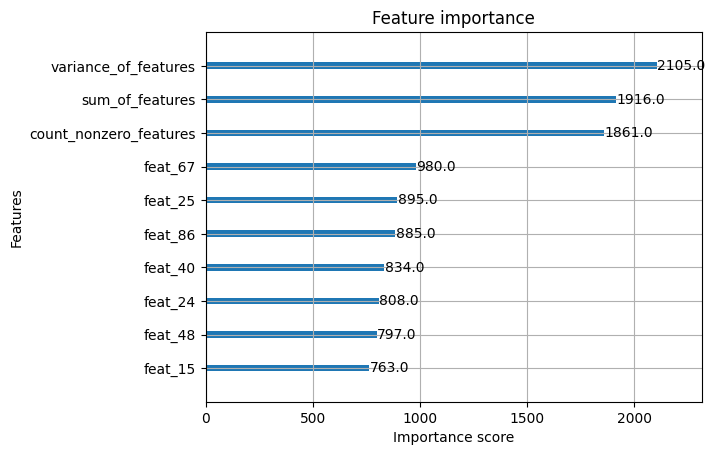

In [15]:
import matplotlib.pyplot as plt

# Feature Importance Plot
xgb.plot_importance(xgb_model, max_num_features=10)  # Top 10 Features
plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV

# Parametergrid definieren
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# GridSearchCV initialisieren
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_encoded)), eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

# Grid Search ausführen
grid_search.fit(X_train, y_train)

# Beste Parameter und Score
print("Beste Parameter:", grid_search.best_params_)
print("Beste Accuracy:", grid_search.best_score_)

# Beste Modell für Vorhersagen verwenden
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Test Accuracy mit bestem Modell: {accuracy_score(y_test, y_pred_best):.4f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

In [18]:
from sklearn.model_selection import GridSearchCV

# Parametergrid definieren
param_grid = {
    'max_depth': [50],
    'n_estimators': [300]
  
  
  
}

'''
# Parametergrid definieren
param_grid = {
    'max_depth': [50],
    'learning_rate': [0.3],
    'n_estimators': [300],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'reg_alpha': [0.01],
    'reg_lambda': [1.0]
}
'''
# GridSearchCV initialisieren
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_encoded)), eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,
    verbose=1
)

# Grid Search ausführen
grid_search.fit(X_train, y_train)

# Beste Parameter und Score
print("Beste Parameter:", grid_search.best_params_)
print("Beste Accuracy:", grid_search.best_score_)

# Beste Modell für Vorhersagen verwenden
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Test Accuracy mit bestem Modell: {accuracy_score(y_test, y_pred_best):.4f}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Beste Parameter: {'max_depth': 50, 'n_estimators': 300}
Beste Accuracy: 0.8450167881418393
Test Accuracy mit bestem Modell: 0.8691


In [19]:
from sklearn.model_selection import GridSearchCV

# XGBoost-Modell mit den gewünschten Parametern initialisieren
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    max_depth=50,
    n_estimators=300,
    learning_rate=0.1, 
   # min_child_weight=4,
    colsample_bytree=0.8,
    subsample=0.9,
    random_state=0
)

# Modell trainieren
xgb_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_best = xgb_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")


Test Accuracy: 0.8749
